## 1. Discussion and Background of the Business Problem:

### Indian Restaurants 
## Introduction Section

This final project explores the best locations for Indian restaurants throughout the Queens of New York. New York is a major
metropolitan area with more than 8.4 million (Quick Facts, 2018) people living within city limits. New York City is the largest city in the United States with a long history of international immigration. People came from many parts of the world. According to the 2007 American Community Survey estimates, New York City is home to approximately 315,000 people from the Indian subcontinent. With its diverse culture, comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese, Indian, French, etc.

## Target Audience

• Business personnel who wants to invest or open a restaurant.                                                                                                                                                                   
• The freelancer who loves to have their own restaurant as a side business.                                                                                                                                                     
• Finding the best location for opening a restaurant.                                                                                                                                                                           
• Budding Data Scientists, who want to implement some of the most used.                                                                                                                                                         
• Exploratory Data Analysis techniques to obtain necessary data, analyze it and, finally be able to tell a story out of it.                                                                                                     

### Problem Statement

1. What is the best location for an Indian restaurant in Queens, New York City?                                                                                                                                               
2. In what Neighborhood should I open an Indian restaurant to have the best chance of being successful?

### Data Section

For this project we need the following data:                                                                                                                                                                                  
1. New York City data that contains Borough, Neighborhoods along with their latitudes and longitudes                                             
• Data Source: https://cocl.us/new_york_dataset                                                                                                                                                                               
• Description: This data set contains the required information. And we will use this data set to explore various neighborhoods of New York city.      
2. Indian restaurants in Queens neighborhood of New York city.      
• Data Source: Foursquare API                    
• Description: By using this API we will get all the venues in the Queens neighborhood. We can filter these venues to get only Indian restaurants.

### Approach

Collect the New York city data from https://cocl.us/new_york_dataset. 

• Using Foursquare API we will get all venues for each neighborhood.                                                                                                                                                           
• Filter out all venues which are Indian Restaurants.                                                                                                                                                                         
• Data Visualization and some statistical analysis.                                                                                                                                                                           
• Analyzing using Clustering (Specially K-Means):  
 1. Find the best value of K                                                                                                                                                                                                 
 2. Visualize the neighborhood with several Indian Restaurants.  
 
• Compare the Neighborhoods to Find the Best Place for Starting up a Restaurant.                                                                                                                                               
• Inference From these Results and related Conclusions

## 2. Data Preparation:

I will use New York City data for this project.

### Before we get the data and start exploring it, let's import all required libraries .

In [3]:
import seaborn as sns

In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::ibm-wsrt-py37main-keep==0.0.0=2155
  - conda-forge/linux-64::pytorch==1.8.0=cpu_py37ha70c682_1
  - defaults/noarch::ibm-wsrt-py37main-main==custom=2155
done

# All requested packages already installed.

Libraries imported.


### My variables

In [5]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'B2LGB1M5TNDZSN2CUOMS3A3LWZ05DC4S2L3EYKV10D3RCYAU' # your Foursquare ID
CLIENT_SECRET = 'IQNCKAUJOASZ0VL0E45VU1FLO4OZYDUT1AFOTKHPSRTPVCML' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Now let's define the functions we are going to use later in this project

In [6]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### Now let's use the above codes to get our initial NYC data

In [7]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
ny_data.shape

(306, 4)

### Initial Data Analysis

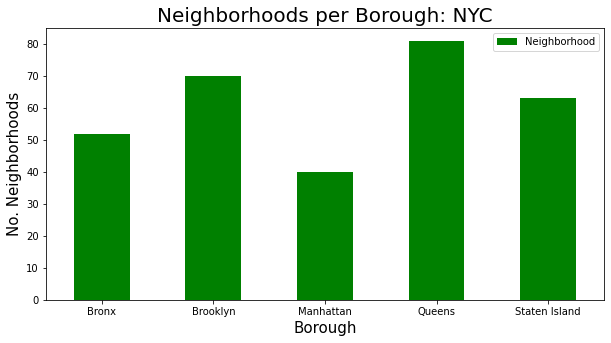

In [9]:
clr = "green"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

### Let's analyze further and see how many Indian restaurants there are in each neighborhood and borough. After it, graph the results.

In [11]:
# queens has most neighborhoods
# prepare neighborhood list that contains Indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    print(row)
    for resturant_detail in indian_restaurants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
['Bronx', '

( 68 / 306 ) Indian Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Indian Restaurants in Gowanus, Brooklyn:1
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Indian Restaurants in Fort Greene, Brooklyn:1
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Indian Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Indian Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Indian Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Indian Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Indian Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]


( 132 / 306 ) Indian Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Indian Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Indian Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Indian Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Indian Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Indian Restaurants in Kew Gardens, Queens:1
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Indian Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Indian Restaurants in Flushing, Queens:0
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Indian Re

( 199 / 306 ) Indian Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Indian Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Indian Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Indian Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Indian Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Indian Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Indian Restaurants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Indian Restaurants in Port Richmond, 

( 260 / 306 ) Indian Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Indian Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Indian Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Indian Restaurants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Indian Restaurants in Jamaica Hills, Queens:2
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Indian Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Indian Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Indian Restaurants in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
(

In [12]:
#indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv')

In [13]:
indian_ny = pd.read_csv('indian_rest_ny_tocsv1.csv')
indian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
35,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares
36,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant
37,Queens,Jamaica Hills,4c69c4b58e7c0f47d48de00f,Ghoroa Sweets & Restaurant
38,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux
39,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen


In [14]:
indian_rest_ny.shape

(40, 4)


We got 40 Indian Restaurants across the New York City.

As we continue our analysis, we see below that although Manhattan had the least number of neighborhoods, it does have the highest number of Indian restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Murray Hill has the highest number of Indian restaurants in all of NYC and is actually located in the boroughs of Manhattan and Queens.

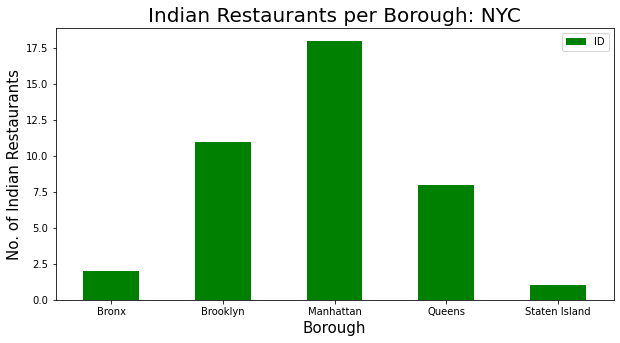

In [15]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

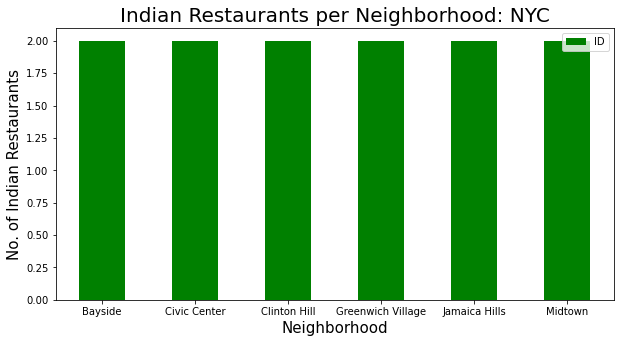

In [16]:
NOofNeigh = 6 # top number for graphing all the same past 6
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [25]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Bayside']

,Borough,Neighborhood,ID,Name
29,Queens,Bayside,4f1f4996e4b01ff351a7a50c,Ayna Agra Indian Restaurant
30,Queens,Bayside,502063b4e4b0c49dd7e1f9b5,Agra Indian Cuisine


Now we will get the ranking of each restaurant for further analysis.

In [26]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '608a76872a9c940229f1bc87'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '608a768712a98277f9db0ec4'}, 'response': {'venue': {'id': '545835a1498e820edc6f636f', 'name': 'Bombay Grill', 'contact': {'phone': '7184912500', 'formattedPhone': '(718) 491-2500'}, 'location': {'address': '8716 3rd Ave', 'lat': 40.622371, 'lng': -74.03179899999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.622371, 'lng': -74.03179899999999}, {'label': 'entrance', 'lat': 40.622344, 'lng': -74.031673}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8716 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-grill/545835a1498e820edc6f636f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4

{'meta': {'code': 200, 'requestId': '608a768887f6d507647120b0'}, 'response': {'venue': {'id': '4b8ffc16f964a520246e33e3', 'name': 'Curry Heights', 'contact': {'phone': '7182609000', 'formattedPhone': '(718) 260-9000', 'twitter': 'curryheights'}, 'location': {'address': '151 Remsen St', 'crossStreet': 'btwn Court St & Clinton St', 'lat': 40.69357223828141, 'lng': -73.99226545349896, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69357223828141, 'lng': -73.99226545349896}, {'label': 'entrance', 'lat': 40.693578, 'lng': -73.992235}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['151 Remsen St (btwn Court St & Clinton St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-heights/4b8ffc16f964a520246e33e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4

{'meta': {'code': 200, 'requestId': '608a7689ef198728f6829cec'}, 'response': {'venue': {'id': '57596dad498e732300496b23', 'name': 'Dosa Royale', 'contact': {'phone': '7185763800', 'formattedPhone': '(718) 576-3800'}, 'location': {'address': '258 Dekalb Ave', 'lat': 40.689466368706604, 'lng': -73.96870434089776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689466368706604, 'lng': -73.96870434089776}], 'postalCode': '11205', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['258 Dekalb Ave', 'New York, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dosa-royale/57596dad498e732300496b23', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 24}, 'url': 'http://www.dosaroyale.com', 

{'meta': {'code': 200, 'requestId': '608a7689c31c135a601c177b'}, 'response': {'venue': {'id': '568d3902498e619efcbc3f58', 'name': 'Spice & Grill', 'contact': {}, 'location': {'address': '441 Myrtle Ave', 'crossStreet': 'Waverly', 'lat': 40.693389, 'lng': -73.968028, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693389, 'lng': -73.968028}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['441 Myrtle Ave (Waverly)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/spice--grill/568d3902498e619efcbc3f58', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 21, 'gro

{'meta': {'code': 200, 'requestId': '608a76892a9c940229f1c137'}, 'response': {'venue': {'id': '543870ec498ec64de510608d', 'name': 'Masala Grill', 'contact': {}, 'location': {'address': 'Atlantic Avenue', 'crossStreet': '3rd Avenue', 'lat': 40.68554017378092, 'lng': -73.98120188318653, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68554017378092, 'lng': -73.98120188318653}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Atlantic Avenue (3rd Avenue)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/masala-grill/543870ec498ec64de510608d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'url': 'http://masalagrillbk.com', 'price': {'tie

{'meta': {'code': 200, 'requestId': '608a768a750b7e19745ccf8e'}, 'response': {'venue': {'id': '4bb93b70cf2fc9b6fe64a002', 'name': 'Gandhi Fine Indian Cuisine', 'contact': {'phone': '7182827012', 'formattedPhone': '(718) 282-7012'}, 'location': {'address': '2032 Bedford Ave', 'crossStreet': 'btwn Clarkson Ave & Parkside Ave', 'lat': 40.65516762218564, 'lng': -73.95632450081226, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65516762218564, 'lng': -73.95632450081226}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2032 Bedford Ave (btwn Clarkson Ave & Parkside Ave)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gandhi-fine-indian-cuisine/4bb93b70cf2fc9b6fe64a002', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 's

{'meta': {'code': 200, 'requestId': '608a768a5788171d05a51366'}, 'response': {'venue': {'id': '4ae7876ef964a5201eac21e3', 'name': 'Kismat Indian Restaurant', 'contact': {'phone': '2127958633', 'formattedPhone': '(212) 795-8633', 'twitter': 'kismatindian'}, 'location': {'address': '603 Fort Washington Ave', 'crossStreet': '187th St', 'lat': 40.855221723964846, 'lng': -73.93696683600031, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855221723964846, 'lng': -73.93696683600031}], 'postalCode': '10040', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['603 Fort Washington Ave (187th St)', 'New York, NY 10040', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kismat-indian-restaurant/4ae7876ef964a5201eac21e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '

( 15 / 40 ) processed
{'meta': {'code': 200, 'requestId': '608a768b501cc875260bda82'}, 'response': {'venue': {'id': '529d382a11d2dd5ef107e641', 'name': 'Chapati House - NYC', 'contact': {'phone': '2127497200', 'formattedPhone': '(212) 749-7200', 'twitter': 'chapatihousenyc'}, 'location': {'address': '3153 Broadway', 'crossStreet': 'Tiemann Pl.', 'lat': 40.81457249971737, 'lng': -73.95915381671377, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81457249971737, 'lng': -73.95915381671377}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3153 Broadway (Tiemann Pl.)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chapati-house--nyc/529d382a11d2dd5ef107e641', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '608a768b5788171d05a514b5'}, 'response': {'venue': {'id': '4e221f671495f18f035610f6', 'name': 'Mumtaz', 'contact': {'phone': '2128794797', 'formattedPhone': '(212) 879-4797'}, 'location': {'address': '1582 York Ave', 'lat': 40.7741338, 'lng': -73.9482272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7741338, 'lng': -73.9482272}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1582 York Ave', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mumtaz/4e221f671495f18f035610f6', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 11}, 'url': 'http://mumtaznyc.com', 'price': {'tier': 2, 'message': 'Moderate', 'cu

{'meta': {'code': 200, 'requestId': '608a768c512b0e2732968e4f'}, 'response': {'venue': {'id': '4b4aab62f964a520978c26e3', 'name': 'Dil-e Punjab Deli', 'contact': {'phone': '2126479428', 'formattedPhone': '(212) 647-9428', 'twitter': 'dilepunjabdeli'}, 'location': {'address': '170 9th Ave', 'crossStreet': 'at 21st St', 'lat': 40.74484451009235, 'lng': -74.00252750283143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74484451009235, 'lng': -74.00252750283143}, {'label': 'entrance', 'lat': 40.744917, 'lng': -74.002266}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['170 9th Ave (at 21st St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dile-punjab-deli/4b4aab62f964a520978c26e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '608a768c8c9997729b9886b8'}, 'response': {'venue': {'id': '4593ed04f964a52050401fe3', 'name': 'The Kati Roll Company', 'contact': {'phone': '2124206517', 'formattedPhone': '(212) 420-6517'}, 'location': {'address': '99 Macdougal St', 'crossStreet': 'btwn Bleecker & W 3rd St', 'lat': 40.7295697222648, 'lng': -74.00086061309852, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7295697222648, 'lng': -74.00086061309852}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['99 Macdougal St (btwn Bleecker & W 3rd St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-kati-roll-company/4593ed04f964a52050401fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '608a768cbb1cb77d2fdd0880'}, 'response': {'venue': {'id': '5803c0db38fa71491b748a7d', 'name': 'Taco Mahal', 'contact': {'phone': '6467191553', 'formattedPhone': '(646) 719-1553', 'instagram': 'tacomahalnyc', 'facebook': '575545749278543', 'facebookUsername': 'TacoMahalnyc', 'facebookName': 'Taco Mahal'}, 'location': {'address': '73 7th Ave S', 'lat': 40.73240508476288, 'lng': -74.00350113625272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73240508476288, 'lng': -74.00350113625272}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['73 7th Ave S', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taco-mahal/5803c0db38fa71491b748a7d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 's

{'meta': {'code': 200, 'requestId': '608a768de463196458cb6861'}, 'response': {'venue': {'id': '5b770657c0cacb002c89bc63', 'name': 'The Kati Roll Company', 'contact': {}, 'location': {'address': '22 Maiden Ln', 'lat': 40.70911435070483, 'lng': -74.0090911929708, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70911435070483, 'lng': -74.0090911929708}], 'postalCode': '10038', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['22 Maiden Ln', 'New York, NY 10038', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-kati-roll-company/5b770657c0cacb002c89bc63', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 2

{'meta': {'code': 200, 'requestId': '608a768d663a6f307fd2d23d'}, 'response': {'venue': {'id': '5782c9ce498edde587f5aa14', 'name': 'Tikka Indian Grill', 'contact': {'phone': '7184801307', 'formattedPhone': '(718) 480-1307'}, 'location': {'address': '119-30 Metropolitan Ave', 'lat': 40.70587364181698, 'lng': -73.83094233462995, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70587364181698, 'lng': -73.83094233462995}], 'postalCode': '11415', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119-30 Metropolitan Ave', 'Queens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tikka-indian-grill/5782c9ce498edde587f5aa14', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 2}, 'url': 'http

{'meta': {'code': 200, 'requestId': '608a768eae879258d16320df'}, 'response': {'venue': {'id': '4b3a8aa5f964a520996925e3', 'name': 'Sajni 026', 'contact': {'phone': '7182750606', 'formattedPhone': '(718) 275-0606'}, 'location': {'address': '9810 Queens Blvd', 'crossStreet': '65th Rd.', 'lat': 40.728123, 'lng': -73.858071, 'labeledLatLngs': [{'label': 'display', 'lat': 40.728123, 'lng': -73.858071}, {'label': 'entrance', 'lat': 40.728194, 'lng': -73.85792}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9810 Queens Blvd (65th Rd.)', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sajni-026/4b3a8aa5f964a520996925e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False

{'meta': {'code': 200, 'requestId': '608a768f067be71063805167'}, 'response': {'venue': {'id': '502063b4e4b0c49dd7e1f9b5', 'name': 'Agra Indian Cuisine', 'contact': {}, 'location': {'address': '213-35 39th Ave', 'lat': 40.76539561313631, 'lng': -73.77153546999746, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76539561313631, 'lng': -73.77153546999746}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['213-35 39th Ave', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/agra-indian-cuisine/502063b4e4b0c49dd7e1f9b5', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count':

{'meta': {'code': 200, 'requestId': '608a768ff365de0547b96d6e'}, 'response': {'venue': {'id': '5a1e961c1987ec47beed877d', 'name': 'Baar Baar', 'contact': {'phone': '2122281200', 'formattedPhone': '(212) 228-1200', 'twitter': 'baarbaarnyc', 'instagram': 'baarbaarnyc', 'facebook': '478023699251632', 'facebookUsername': 'baarbaarnyc', 'facebookName': 'Baar Baar'}, 'location': {'address': '13 E 1st St', 'crossStreet': 'btw Bowery & 2nd Ave', 'lat': 40.724533801523286, 'lng': -73.99162419418478, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724533801523286, 'lng': -73.99162419418478}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13 E 1st St (btw Bowery & 2nd Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/baar-baar/5a1e961c1987ec47beed877d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'In

{'meta': {'code': 200, 'requestId': '608a768f2a9c940229f1cce6'}, 'response': {'venue': {'id': '575dea4c498e2739e43a27e2', 'name': 'Aahar Indian Cuisine', 'contact': {'phone': '6466493374', 'formattedPhone': '(646) 649-3374'}, 'location': {'address': '10 Murray St', 'crossStreet': 'Broadway', 'lat': 40.71330656515891, 'lng': -74.00799405698501, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71330656515891, 'lng': -74.00799405698501}], 'postalCode': '10007', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10 Murray St (Broadway)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/aahar-indian-cuisine/575dea4c498e2739e43a27e2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

{'meta': {'code': 200, 'requestId': '608a7690bba5f12ddb61eaa1'}, 'response': {'venue': {'id': '4c434b2bd691c9b6ef8f8f0a', 'name': 'Sagar Restaurant', 'contact': {'phone': '7182985696', 'formattedPhone': '(718) 298-5696'}, 'location': {'address': '168-25 B Hillside Ave', 'lat': 40.710328623498505, 'lng': -73.79412262466633, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710328623498505, 'lng': -73.79412262466633}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-25 B Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-restaurant/4c434b2bd691c9b6ef8f8f0a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url': 'http://

{'meta': {'code': 200, 'requestId': '608a7690a74b43585d6a7230'}, 'response': {'venue': {'id': '4fe4fb50c2eee335e4fea69d', 'name': 'Moti Mahal Delux', 'contact': {'phone': '2123713535', 'formattedPhone': '(212) 371-3535', 'twitter': 'motimahalus', 'facebook': '464790890213866', 'facebookUsername': 'MotiMahalDeluxNYC', 'facebookName': 'Moti Mahal Delux, NYC'}, 'location': {'address': '1149 1st Ave', 'crossStreet': '63rd Street', 'lat': 40.76209761945207, 'lng': -73.96028513480461, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76209761945207, 'lng': -73.96028513480461}, {'label': 'entrance', 'lat': 40.762073, 'lng': -73.960379}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1149 1st Ave (63rd Street)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/moti-mahal-delux/4fe4fb50c2eee335e4fea69d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'plura

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
35,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares,98,7.5,44
36,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant,10,7.0,6
37,Queens,Jamaica Hills,0,0,0,0.0,0
38,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,186,8.3,83
39,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen,680,8.3,132


In [27]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny_csv.csv') 

In [29]:
indian_rest_stats_ny.shape

(40, 7)

We got statistics for all 40 Indina Restaurants in New York city.

Let's check what values we have in our DataFrame

In [30]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       40 non-null     object 
 1   Neighborhood  40 non-null     object 
 2   ID            40 non-null     object 
 3   Name          40 non-null     object 
 4   Likes         40 non-null     object 
 5   Rating        40 non-null     float64
 6   Tips          40 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.3+ KB


We see that the values like Likes, Tips are string values. We would need to convert them into float for further analysis

In [31]:
indian_rest_stats_ny['Likes'] = indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips'] = indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       40 non-null     object 
 1   Neighborhood  40 non-null     object 
 2   ID            40 non-null     object 
 3   Name          40 non-null     object 
 4   Likes         40 non-null     float64
 5   Rating        40 non-null     float64
 6   Tips          40 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.3+ KB


### Now when the data types look correct, let's continue our analysis.

In [32]:
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,40.000000,40.000000,40.000000
mean,106.400000,7.405000,32.600000
std,192.364744,1.914446,51.595468
min,0.000000,0.000000,0.000000
25%,13.500000,7.100000,6.000000
50%,34.000000,7.950000,15.500000
75%,85.750000,8.400000,28.250000
max,834.000000,9.100000,256.000000


In [33]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                              834.0
Rating                               8.6
Tips                               256.0
Name: 17, dtype: object

In [34]:
# Resturant with maximum Ratings
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                              602.0
Rating                               9.1
Tips                               151.0
Name: 22, dtype: object

In [35]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                              834.0
Rating                               8.6
Tips                               256.0
Name: 17, dtype: object

### Now let's identify and visualize neighborhood with the maximum average rating of restaurants

In [36]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
28,Tribeca,9.1
7,Chelsea,8.9
25,Prospect Lefferts Gardens,8.8
23,Noho,8.8
15,Greenwich Village,8.6
12,Fort Greene,8.6
31,West Village,8.5
21,Midtown,8.5
24,North Side,8.4
27,Sutton Place,8.3


Above are the top neighborhoods with the highest average ratings of Indian restaurants.

In [37]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.233333
4,Staten Island,8.200000
1,Brooklyn,7.463636
0,Bronx,6.750000
3,Queens,5.525000


Similarly these are the average ratings of Indian Restaurants for each Borough

### Let's visualize the results

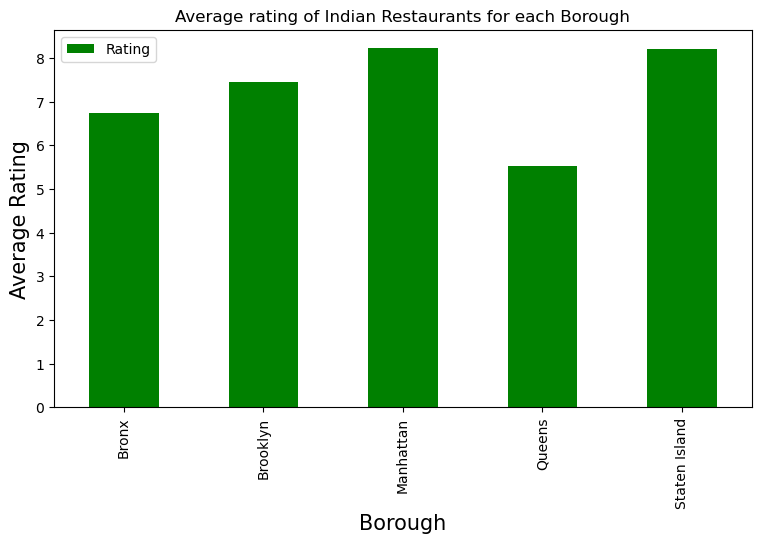

In [38]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map

In [39]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,8.2
3,Boerum Hill,8.2
6,Carnegie Hill,8.1
7,Chelsea,8.9
10,Financial District,8.0
11,Flatiron,8.3
12,Fort Greene,8.6
15,Greenwich Village,8.6
21,Midtown,8.5
22,New Dorp,8.2


We will join this Dataset to original New York data to get longitude and latitude

In [40]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.2
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.2
2,Manhattan,Carnegie Hill,40.782683,-73.953256,8.1
3,Manhattan,Chelsea,40.744035,-74.003116,8.9
4,Staten Island,Chelsea,40.594726,-74.189560,8.9
5,Manhattan,Financial District,40.707107,-74.010665,8.0
6,Manhattan,Flatiron,40.739673,-73.990947,8.3
7,Brooklyn,Fort Greene,40.688527,-73.972906,8.6
8,Manhattan,Greenwich Village,40.726933,-73.999914,8.6
9,Manhattan,Midtown,40.754691,-73.981669,8.5


Now we will show this data on a map

In [41]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Let's add a new field to dataframe for labeling purpose

In [42]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

### Results / Conclusion
Manhattan and Brooklyn have the best rated Indian restaurants on average. Staten Island and The Queens have the least amount of Indian restaurants per borough. However, of note, Tribeca in Manhattan has the highest number of Indian Restaurants in all of NY. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most number of Indian restaurants. Based on the above information, I would state that Manhattan and Brooklyn are the best locations for Indian cuisine in NYC. To have the best shot of success, I would open a Indian restaurant in Brooklyn. Brooklyn has multiple neighborhoods with average ratings exceeding 8.0 on a scale of 1.0 to 10.0 and has less amount of Indian restaurants than Manhattan, making competition easier. Also we should keep in mind, that real estate prices in Brooklyn are much cheaper than in Manhattan. Finally, I would go to The Kati Roll Company in Manhattan for the best Indian food based on 834 likes. As a final note, all of the above analysis is depended on the accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.
